# **About this Project**
In this project, you will implement a Deep Averaging Network for sentiment classification.

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2
# import PyTorch
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data

# Set the seed for PyTorch random number generator
torch.manual_seed(1)

# If gpu is supported, then seed the gpu random number generator as well
gpu_available = torch.cuda.is_available()
if gpu_available:
    torch.cuda.manual_seed(1)

import sys
import matplotlib.pyplot as plt
from helper import *

%matplotlib inline
print('You\'re running python %s' % sys.version.split(' ')[0])
print ("GPU is available:",gpu_available)

You're running python 3.10.12
GPU is available: False


But in the course: You're running python 3.6.8
GPU is available: True

# **Deep Averaging Network**
**Part One: Load Dataset**

We use the multi-domain sentiment dataset created by Professor Mark Dredze for our project. This dataset contains product reviews taken from Amazon.com from many product types and the reviews are labeled positive and negative. In particular, we only consider the reviews for book for our project. To make things easier for you, we also created a dictionary where you will only consider the words in this dictionary when you are constructing the word embedding for your deep averaging network. Run the following two cells to load the data and see a positive and a negative review:

In [ ]:
# First load data
# Calling load_data return the training review, test review and vocabulary
# review_train and review_test are stored as pandas dataframe
# vocabulary is dictionary with key-value pairs (word, index)
# vocabulary[word] = index
# We will use this vocabulary to construct bag-of-word (bow) features
review_train, review_test, vocab = load_data()

# label 0 == Negative reviews
# label 1 == Positive reviews
label_meaning = ['Negative', 'Positive']

print('Number of Training Reviews: ', review_train.shape[0])
print('Number of Test Reviews: ', review_test.shape[0])
print('Number of Words in the Vocabulary: ', len(vocab))

NameError: ignored

In [ ]:
# print some training review
print('A Positive Training Review: ', review_train.iloc[0]['review'])
print('A Negative Training Review: ', review_train.iloc[-1]['review'])

NameError: ignored

We also created a function generate_featurizer which takes in a vocabulary and return a bow featurizer based on the vocabulary. Using the returned featurizer, you can convert a sentence into a bag of word feature vector. See the following cell for example:

In [ ]:
# Create a simple vocabulary
simple_vocab = {'learn': 0, 'machine': 1, 'learning': 2, 'teach': 3}

# Create a simple sentence that will be converted into bag of words features
simple_sentence = ' I learn machine learning to teach machine how to learn.'

# Create a featurizer by passing in the vocabulary
simple_featurizer = generate_featurizer(simple_vocab)

# Call simple_featurizer.transform to transform the sentence to its bag of word features
simple_featurizer.transform([simple_sentence]).toarray()

# You should get array([[2, 2, 1, 1]]) as output.
# This means that the sentence has 2 occurences of 'learn', 2 occurences of 'machine',
# 1 occurence of 'learning' and 1 occurence of 'teach'

Now we will use generate_featurizer to generate a featurizer based on the vocabulary we provided

In [ ]:
# Use the given vocab to generate bag of word featurizer
# See the next cell for an example
bow_featurizer = generate_featurizer(vocab)

Using the featurizer, we will convert the training reviews and test reviews into bag of word representation and PyTorch Tensor

In [ ]:
# convert the reviews to bow representation and torch Tensor
X_train = torch.Tensor(bow_featurizer.transform(review_train['review'].values).toarray())
y_train = torch.LongTensor(review_train['label'].values.flatten())

X_test = torch.Tensor(bow_featurizer.transform(review_test['review'].values).toarray())
y_test = torch.LongTensor(review_test['label'].values.flatten())

In [ ]:
# Generate PyTorch Datasets
trainset = torch.utils.data.TensorDataset(X_train, y_train)
testset = torch.utils.data.TensorDataset(X_test, y_test)

# Generate PyTorch Dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True, drop_last=False)

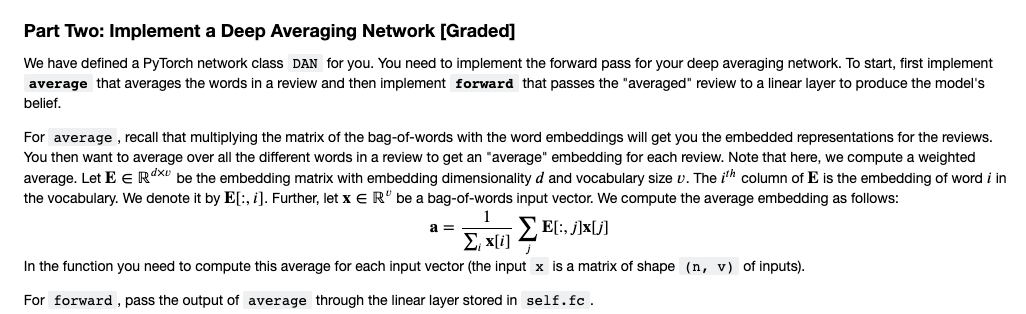

In [ ]:
# Create a Deep Averaging network model class
# embedding_size is the size of the word_embedding we are going to learn
class DAN(nn.Module):
    def __init__(self, vocab_size, embedding_size=32):
        super().__init__()

        # Create a word-embedding of dimension embedding_size
        # self.embeds is now the matrix E, where each column corresponds to the embedding of a word
        self.embeds = torch.nn.Parameter(torch.randn(vocab_size, embedding_size))
        self.embeds.requires_grad_(True)
        # add a final linear layer that computes the 2d output from the averaged word embedding
        self.fc = nn.Linear(embedding_size, 2)

    def average(self, x):
        """
        This function takes in multiple inputs, stored in one tensor x. Each input is a bag of word representation of reviews.
        For each review, it retrieves the word embedding of each word in the review and averages them (weighted by the corresponding
        entry in x).

        Input:
            x: nxv torch Tensor where each row corresponds to bag of word representation of a review

        Output:
            emb: nxd torch Tensor for the averaged review
        """

        emb = None

        # Use bag of words to compute weighted sum of embeddings
        emb = torch.matmul(x, self.embeds)

        # Normalize by total sum of unique words for each review (x is nxv, v is review bow where each column corresponds to a unique word)
        emb = emb / x.sum(dim=1, keepdim=True)

        return emb

    def forward(self, x):
        """
        This function takes in a bag of word representation of reviews. It calls the self.average to get the
        averaged review and pass it through the linear layer to produce the model's belief.

        Input:
            x: nxv torch Tensor where each row corresponds to bag of word representation of reviews

        Output:
            out: nx2 torch Tensor that corresponds to model belief of the input. For instance, output[i][0] is
                 is the model belief that the ith review is negative and output[i][1] is the model belief that
                 the ith review is positive.
        """
        review_averaged = self.average(x)

        out = self.fc(review_averaged)

        return out

In [ ]:
n = 10 # number of reviews
vocab_size = 5 # vocab size
embedding_size = 32 # embedding size
model = DAN(vocab_size, embedding_size)
X = torch.rand(n, vocab_size)
print(X)

In [ ]:
embedding = torch.nn.Embedding(vocab_size, embedding_size)
embedding.weight

In [ ]:
torch.matmul(X, embedding.weight) #X tensor is nxv, number_reviews x bow, 10x5, embedding is vocab_size x embedding_dim, 5x32, output is 10x32

In [ ]:
X.sum(dim=1, keepdim=True) #sum the bow for each review (across the columns), 10x1 vector

In [ ]:
#bow weighted by embeddings for each review divided by the total number of bow per review = average embedding per review
torch.matmul(X, embedding.weight) / X.sum(dim=1, keepdim=True)

In [ ]:
#bow weighted by embeddings for each review divided by the total number of bow per review = average embedding per review
average = torch.matmul(X, embedding.weight) / X.sum(dim=1, keepdim=True)
print(average.shape)
print(average)

In [ ]:
model.fc(average)

In [ ]:
torch.manual_seed(0)
model.average(X)
model.average(X).shape

In [ ]:
model.fc(model.average(X))

In [ ]:
def average_test1(): # check the output dinemsions of the average function
    n = 10 # number of reviews
    vocab_size = 5 # vocab size
    embedding_size = 32 # embedding size
    model = DAN(vocab_size, embedding_size)
    X = torch.rand(n, vocab_size)
    output_size = model.average(X).shape
    # the output of your forward function should be nx2
    return output_size[0] == n and output_size[1] == embedding_size

def average_test2():
    n = 10 # number of reviews
    vocab_size = 3 # vocab size
    embedding_size = 5 # embedding size
    model = DAN(vocab_size, embedding_size)

    # generate a simple input
    X = torch.FloatTensor([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 1],
    ])

    # Get the averaged reviews
    averaged_reviews = model.average(X)

    # Given the input, we know that the first 3 rows corresponds to the first three words
    # The last row should be the average of the three words
    # The diff between the last row and the average of the first three rows should be small
    diff = torch.sum((torch.mean(averaged_reviews[:3], dim=0) - averaged_reviews[3]) ** 2).item()

    return diff < 1e-5

def average_test3():
    n = 10 # number of reviews
    vocab_size = 3 # vocab size
    embedding_size = 5 # embedding size
    model = DAN(vocab_size, embedding_size)

    # generate a simple input
    X = torch.FloatTensor([
        [1, 1, 1],
        [2, 2, 2]
    ])

    # Get the averaged reviews
    averaged_reviews = model.average(X)

    # Since the 2nd review is a multiple of the first,
    # The two averaged review should be the same
    diff = torch.sum((averaged_reviews[0] - averaged_reviews[1])**2).item()

    return diff < 1e-5

def forward_test1():
    n = 10 # number of reviews
    vocab_size = 5 # vocab size
    embedding_size = 32 # embedding size
    model = DAN(vocab_size, embedding_size)

    # call the forward function
    X = torch.rand(n, vocab_size)

    output_size = model(X).shape

    # the output of your forward function should be nx2
    return output_size[0] == n and output_size[1] == 2

def forward_test2():
    n = 10 # number of reviews
    vocab_size = 5 # vocab size
    embedding_size = 32 # embedding size
    model = DAN(vocab_size, embedding_size)
    X = torch.rand(n, vocab_size)

    logits = model(X) # get the output of your forward pass

    averaged_reviews = model.average(X) # get the intermediate averaged review
    logits2 = model.fc(averaged_reviews) # get the model belief using your intermediate average reviews

    return torch.sum((logits - logits2)**2).item() < 1e-5 # Check whether your forward pass is implemented correctly

runtest(average_test1, 'average_test1')
runtest(average_test2, 'average_test2')
runtest(average_test3, 'average_test3')
runtest(forward_test1, 'forward_test1')
runtest(forward_test2, 'forward_test2')

In [ ]:
# Create a model
model = DAN(len(vocab), embedding_size=32)

if gpu_available:
    model = model.cuda()

Part Three: Define the loss function and optimizer

In [ ]:
# Create optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5)

Part Four: Train the network

In [ ]:
# Start Training
num_epochs = 1000

model.train()
for epoch in range(num_epochs):

    # Define the following variables to keep track of the running losses and accuracies
    running_loss = 0.0
    running_acc = 0.0
    count = 0

    for i, (X, y) in enumerate(trainloader):

        # use gpu if necessary
        if gpu_available:
            X = X.cuda()
            y = y.cuda()

        # clear the gradient buffer
        optimizer.zero_grad()

        # Do forward propagation to get the model's belief
        logits = model(X)

        # Compute the loss
        loss = loss_fn(logits, y)

        # Run a backward propagation to get the gradient
        loss.backward()

        # Update the model's parameter
        optimizer.step()

        # Get the model's prediction
        pred = torch.argmax(logits,dim=1)

        # Update the running statistics
        running_acc += torch.sum((pred == y).float()).item()
        running_loss += loss.item()
        count += X.size(0)

    # print the running statistics after training for 100 epochs
    if (epoch + 1) % 100 == 0:
        print('Epoch [{} / {}] Average Training Accuracy: {:4f}'.format(epoch + 1, num_epochs, running_acc / count))
        print('Epoch [{} / {}] Average Training loss: {:4f}'.format(epoch + 1, num_epochs, running_loss / len(trainloader)))

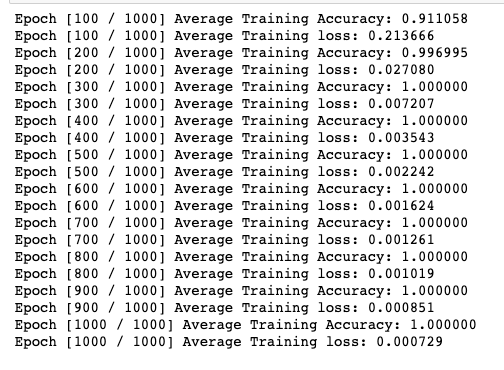

Step 5: Evaluate your model on the test data

See the a random test review and the model prediction. (You may observe that neural networks achieve high accuracy - but tend to be over-confident. This is because they achieve 100% training accuracy early on in the learning procedure and therefore learn that they tend to be always right.)

In [ ]:
# Evaluate the model
model.eval()

# Define the following variable to keep track of the accuracy
running_acc = 0.0
count = 0.0

for (X, y) in testloader:
    # Use gpu if available
    if gpu_available:
        X = X.cuda()
        y = y.cuda()

    # Do a forward pass and tell PyTorch that no gradient is necessary to save memory
    with torch.no_grad():
        logits = model(X)

    # Calculate the prediction
    pred = torch.argmax(logits,dim=1)

    # Update the running stats
    running_acc += torch.sum((pred == y).float()).item()
    count += X.size(0)

print('Your Test Accuracy is {:.4f}'. format(running_acc / count))

Tensorflow approach

In [ ]:
import tensorflow as tf

In [ ]:
# convert the reviews to bow representation and tf Tensor
X_train = tf.convert_to_tensor(bow_featurizer.transform(review_train['review'].values).toarray())
y_train = tf.convert_to_tensor(review_train['label'].values.flatten(), dtype=tf.int64)

X_test = tf.convert_to_tensor(bow_featurizer.transform(review_test['review'].values).toarray())
y_test = tf.convert_to_tensor(review_test['label'].values.flatten(), dtype=tf.int64)

NameError: ignored

Like we did in the previous projects, we will use the compile and fit in-built functions for our deep-averaging network. But performing the averaging step is tricky in Tensorflow as it does not give us control over how forward propagation is performed. The solution to this problem is to define our own averaging layer in Tensorflow, which can be included in Sequential when creating the model.

In [ ]:
# Create model
class TFAveragingLayer(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_size=32):
        super().__init__()
        self.embeds = self.add_weight(
            'embeds', shape=[vocab_size, embedding_size]
        )

    def call(self, x):
        return tf.matmul(x, self.embeds) / tf.reduce_sum(x, axis=1, keepdims=True)

model = tf.keras.Sequential([
    tf.keras.Input((len(vocab))),
    TFAveragingLayer(len(vocab), embedding_size=32),
    tf.keras.layers.Dense(2, activation=None)
])

model.summary()

# Create optimizer and loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=5)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history = model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    verbose=0,
    callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=100)]
)

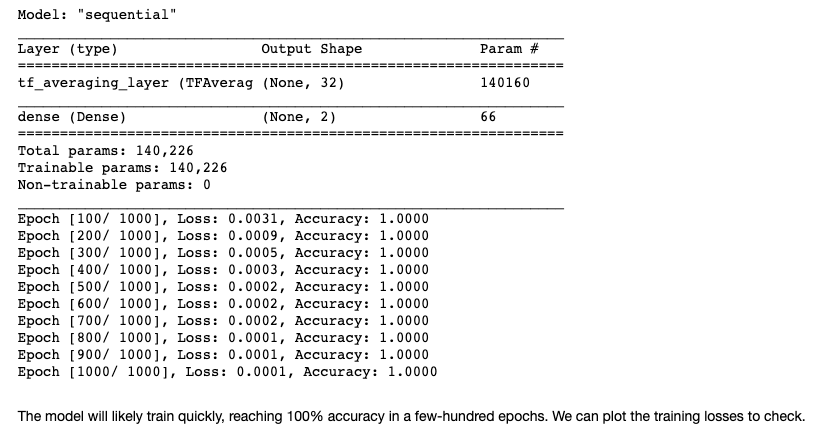

In [ ]:
plt.plot(np.arange(num_epochs) + 1, history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

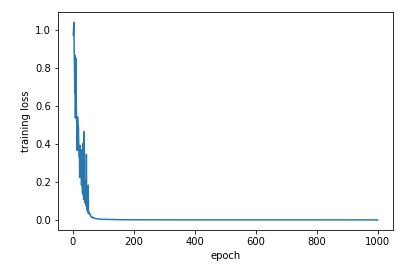

In [ ]:
## Evaluate the network
logits = model(X_test)

# Calculate the prediction
pred = tf.argmax(logits, axis=1)

# Update the running stats
acc = tf.reduce_mean(tf.cast(pred == y_test, tf.float32)).numpy()
print('Your Test Accuracy is {:.4f}'. format(acc))

Your Test Accuracy is 0.9050

We can again check how confident this Tensorflow model is on the target test review. Like before, this model will be extremely confident in its prediction, regardless of correctness.

In [ ]:
bog_target = tf.expand_dims(X_test[target], axis=0)
logits_target = model(bog_target)

pred = tf.argmax(logits_target, axis=1)
probability = tf.exp(tf.squeeze(logits_target)) \
            / tf.reduce_sum(tf.exp(tf.squeeze(logits_target)))

print('Review: ', review_target)
print('Ground Truth: ', label_meaning[int(label_target)])
print('Prediction: %s (Certainty %2.2f%%)' % (label_meaning[int(pred.numpy())], 100.0*probability[int(pred.numpy())]))

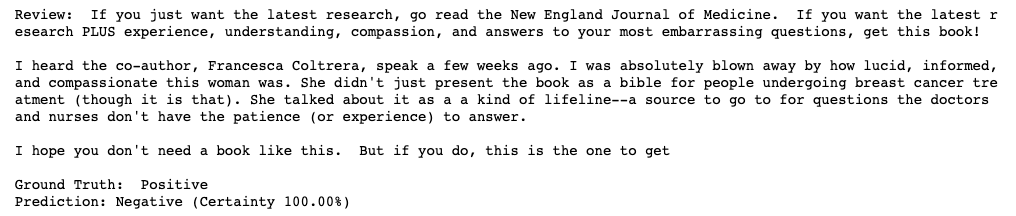